In [1]:
### Librerias
#>
import os
import giddy
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import mapclassify as mc
import matplotlib.pyplot as plt
from libpysal.weights.contiguity import Queen
from matplotlib.colors import LinearSegmentedColormap

import warnings
warnings.filterwarnings("ignore", category = DeprecationWarning)

In [ ]:
### Entradas y Salidas

Entradas =  '---- '
ENTRADAS_BASES = '---'

In [3]:
### Función de lectura de multiples xlsx en una carpeta (misma forma xlsx)
def Archivos_Carpeta(carpeta):
    """
    Lee todos los archivos .xlsx en una carpeta, valida que tengan las mismas columnas,
    agrega el nombre del archivo y la fecha de referencia como columnas extra,
    concatena todos en un solo DataFrame y genera un catálogo resumen.

    Argumentos:
    carpeta : str
        Ruta de la carpeta que contiene los archivos de Excel.

    Retorna:
    tuple :
        - df_concatenado : pd.DataFrame
            DataFrame concatenado de todos los archivos, incluyendo columnas 'Archivo' y 'Fecha'.
        - catalogo_df : pd.DataFrame
            DataFrame resumen con nombre de archivo, número de filas y fecha.
    """

    # Mapeo de abreviaturas de meses en español a número de mes
    meses_es = {
        'Ene': 1, 'Feb': 2, 'Mar': 3, 'Abr': 4, 'May': 5, 'Jun': 6,
        'Jul': 7, 'Ago': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dic': 12
    }

    archivos_excel = [os.path.join(carpeta, archivo) for archivo in os.listdir(carpeta) if archivo.endswith('.xlsx')]

    if not archivos_excel:
        raise ValueError("No se encontraron archivos .xlsx en la carpeta.")

    dataframes = []
    catalogo = []
    columnas_base = None

    for archivo in archivos_excel:
        try:
            # Lee el archivo completo
            df = pd.read_excel(archivo)

            # Inicializa columnas base con el primer archivo
            if columnas_base is None:
                columnas_base = list(df.columns)
            else:
                if list(df.columns) != columnas_base:
                    raise ValueError(f"Las columnas del archivo '{os.path.basename(archivo)}' no coinciden con las columnas base.")

            # Procesa el nombre del archivo para extraer la fecha
            nombre_archivo = os.path.basename(archivo).replace('.xlsx', '')
            mes_abrev = nombre_archivo[:3]
            año = int(nombre_archivo[3:])

            if mes_abrev not in meses_es:
                raise ValueError(f"No se reconoce el mes '{mes_abrev}' en el archivo '{nombre_archivo}'.")

            mes = meses_es[mes_abrev]
            fecha = pd.Timestamp(year=año, month=mes, day=1)

            # Agrega columnas 'Archivo' y 'Fecha' al DataFrame
            df['Archivo'] = os.path.basename(archivo)
            df['Fecha'] = fecha

            # Guarda información para el catálogo
            catalogo.append({
                "Archivo": os.path.basename(archivo),
                "Filas": len(df),
                "Fecha": fecha
            })

            dataframes.append(df)

        except Exception as e:
            print(f"Error procesando el archivo '{archivo}': {e}")

    # Concatena todos los DataFrames
    if dataframes:
        df_concatenado = pd.concat(dataframes, ignore_index=True)
        catalogo_df = pd.DataFrame(catalogo).sort_values('Fecha').reset_index(drop=True)
        print("Todos los archivos han sido leídos y concatenados exitosamente.")
        return df_concatenado, catalogo_df
    else:
        raise ValueError("No se pudieron procesar los archivos.")

In [4]:
### > Lectura de multiples archivos xlsx de la carpeta
#>
carpeta_entrada = Entradas
Usuarios, Usuarios_Catalogo = Archivos_Carpeta(carpeta_entrada)
globals().update(Usuarios)

Todos los archivos han sido leídos y concatenados exitosamente.


In [5]:
### Base de uso - parte 00

UN_DESCO = ['R6_10B', 'R6_10C', 'R6_11A', 'R6_12A', 'R6_13A', 'R6_13B', 'R6_13C',
            'R6_14A', 'R6_14B', 'R6_15A', 'R6_16A', 'R6_17A', 'R6_18A', 'R6_18B', 'R6_18C',
            'R6_19A', 'R6_1A', 'R6_20A', 'R6_20B', 'R6_21A', 'R6_22B', 'R6_23A', 'R6_24A',
            'R6_24B', 'R6_25A', 'R6_25B', 'R6_25C', 'R6_26A', 'R6_27A', 'R6_27C', 'R6_27D',
            'R6_27E', 'R6_28A', 'R6_29A', 'R6_29B', 'R6_29D', 'R6_2A', 'R6_2B', 'R6_30A',
            'R6_31A', 'R6_32A', 'R6_32B', 'R6_32C', 'R6_32D', 'R6_3A', 'R6_4A', 'R6_5A',
            'R6_5B', 'R6_5C', 'R6_6A', 'R6_7A', 'R6_7B', 'R6_8A', 'R6_8B', 'R6_9A']

Base_Uso = Usuarios[Usuarios['CLAVE_UNIDAD'].isin(UN_DESCO)].copy()

In [6]:
### Base de uso (pivot) - parte 01

Piv_Tab = Base_Uso.pivot(index = ['CLAVE_UNIDAD', 'AMBITO', 'UNIDAD', 'LOCAL', 'REGION'],
                         columns = 'Fecha',
                         values = 'Ua_IndiceIntegral')

Piv_Tab = Piv_Tab.sort_index(axis = 1) 
Piv_Tab = Piv_Tab.reset_index() 

In [7]:
### Base de uso (merge) - parte 02

MAPA_BASE = gpd.read_file(ENTRADAS_BASES + 'MAP_UAD.json')

Data_Markov = MAPA_BASE.merge(Piv_Tab, left_on = 'UNIDAD_ADM',
                              right_on = 'CLAVE_UNIDAD', 
                              how = 'left').drop({'UNIDAD_ADM',
                                                  'Unidad',
                                                  'Local'}, axis = 1)

### Markov Espacial

In [8]:
### Análisis - Islas

Islas = Data_Markov['CLAVE_UNIDAD'].value_counts()
Islas[Islas > 1]

Series([], Name: count, dtype: int64)

In [11]:
### Creación de contigüidad

w = Queen.from_dataframe(Data_Markov)
w.transform = 'r'

C:\Users\LAAR8976\AppData\Local\Temp\ipykernel_19756\1151516766.py:3: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(Data_Markov)


In [12]:
### Análisis de Markov

y = Data_Markov.iloc[:, 6:16].values
sm = giddy.markov.Spatial_Markov(y, w, fixed = True, k = 5, m = 5)
sm.summary()

--------------------------------------------------------------
                     Spatial Markov Test                      
--------------------------------------------------------------
Number of classes: 5
Number of transitions: 495
Number of regimes: 5
Regime names: LAG0, LAG1, LAG2, LAG3, LAG4
--------------------------------------------------------------
   Test                   LR                Chi-2
  Stat.               43.665               52.227
    DOF                   36                   36
p-value                0.178                0.039
--------------------------------------------------------------
P(H0)           C0         C1         C2         C3         C4
     C0      0.821      0.179      0.000      0.000      0.000
     C1      0.192      0.657      0.152      0.000      0.000
     C2      0.010      0.167      0.716      0.108      0.000
     C3      0.000      0.000      0.108      0.824      0.069
     C4      0.000      0.000      0.000      0.031      0

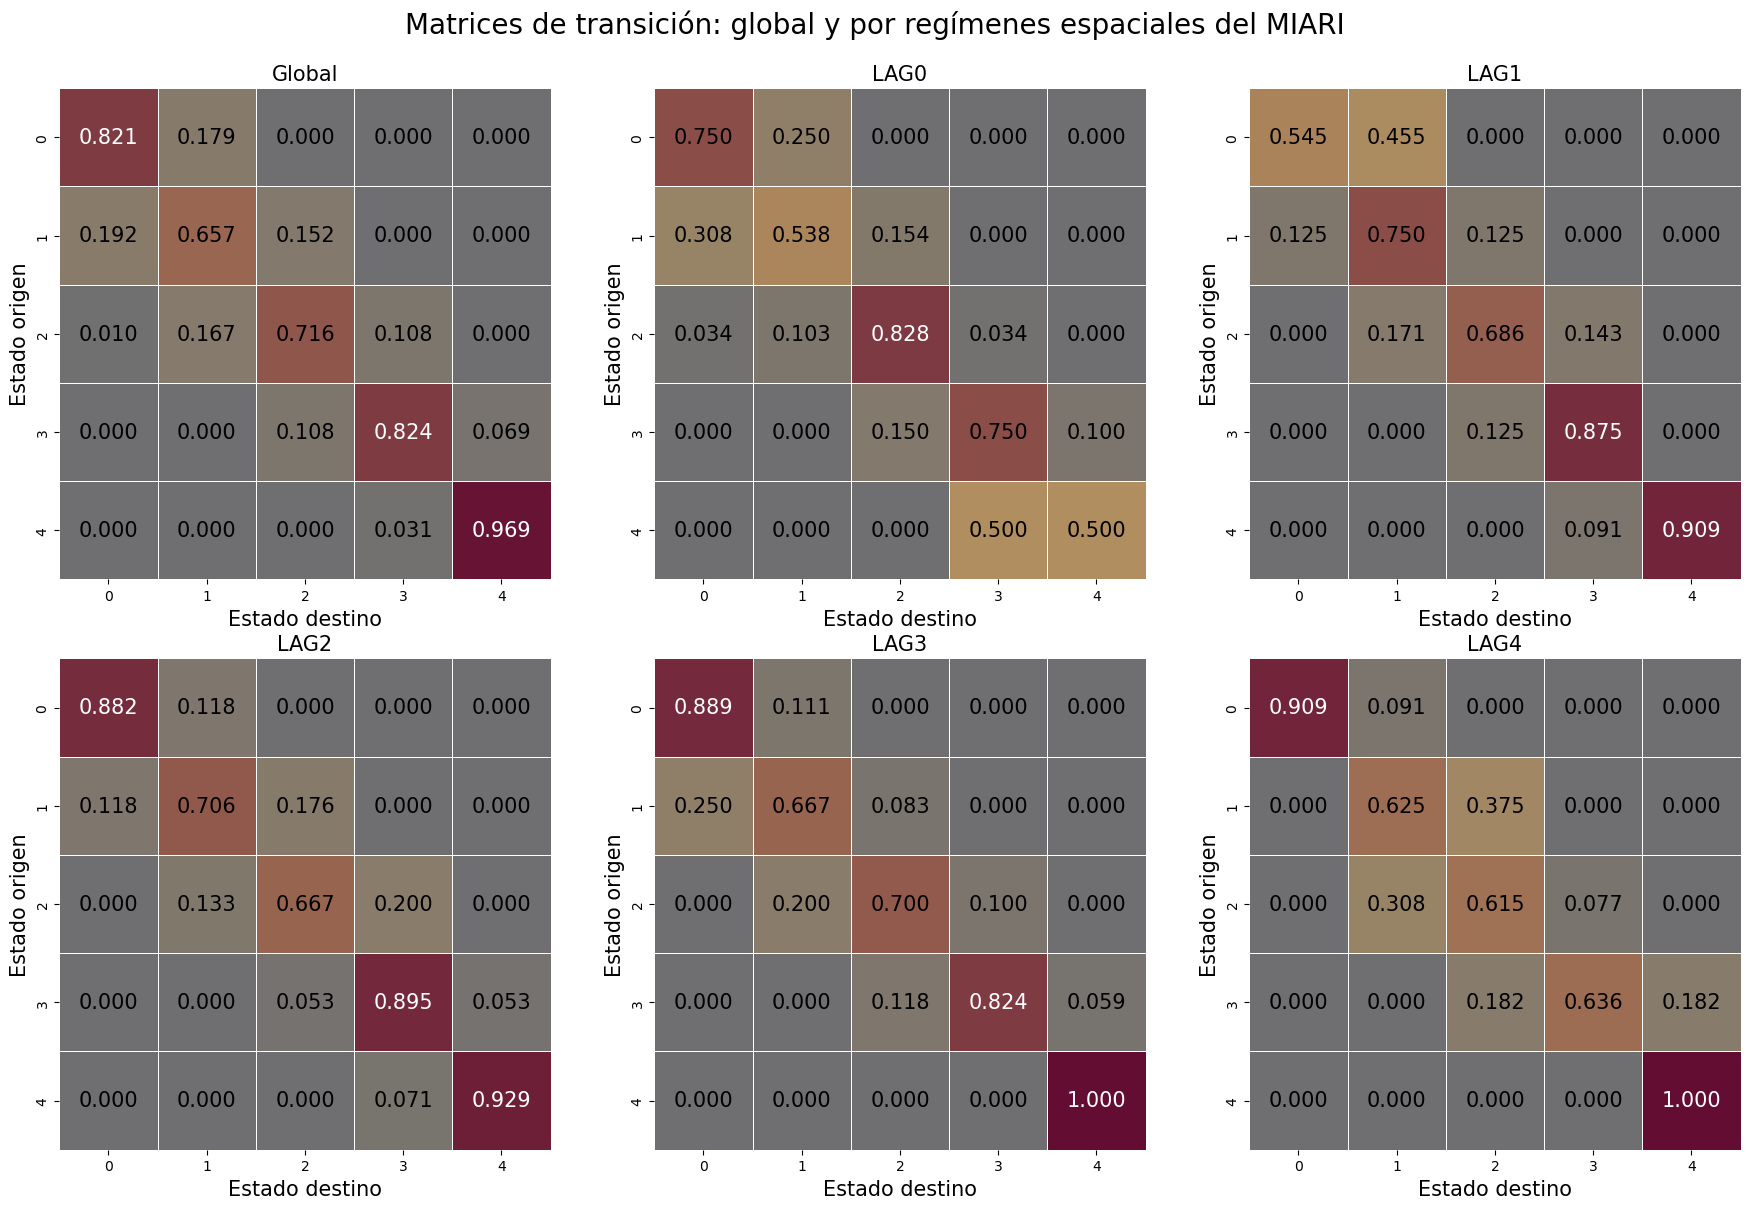

In [15]:
### Matrices de transición de Markov

colors = [(111/255, 111/255, 113/255), 
          (177/255, 143/255, 95/255),
          (99/255, 13/255, 50/255)]

cmap_personalizado = LinearSegmentedColormap.from_list("custom_cmap", colors)

# Número de matrices
n_matrices = 1 + len(sm.P)
n_cols = 3
n_rows = (n_matrices // n_cols) + (n_matrices % n_cols > 0)

# Crear figura
fig, axes = plt.subplots(n_rows, n_cols,
                         figsize = (6*n_cols, 6*n_rows))
axes = axes.flatten()

titulos = ['Global'] + [f"LAG{i}" for i in range(len(sm.P))]

for idx in range(n_matrices):
    ax = axes[idx]
    if idx == 0:
        matriz = sm.p
    else:
        matriz = sm.P[idx-1]
    
    # Heatmap con colores personalizados
    im = sns.heatmap(matriz, annot = False,
                     cmap = cmap_personalizado,
                     vmin = 0, vmax = 1,
                     square = True, linewidths = 0.5,
                     cbar = False, ax = ax)

    for y in range(matriz.shape[0]):
        for x in range(matriz.shape[1]):
            value = matriz[y, x]
            text_color = 'black' if value < 0.8 else 'white'
            ax.text(x + 0.5, y + 0.5, f"{value:.3f}",
                    ha = 'center', va = 'center',
                    color = text_color, fontsize = 15)

    ax.set_title(titulos[idx], fontsize = 15)
    ax.set_xlabel('Estado destino', fontsize = 15)
    ax.set_ylabel('Estado origen', fontsize = 15)

for idx in range(n_matrices, len(axes)):
    axes[idx].axis('off')

plt.suptitle('Matrices de transición: global y por regímenes espaciales del MIARI', fontsize = 20, y = 1)
plt.tight_layout()
plt.show()

In [28]:
import warnings
warnings.filterwarnings("ignore", message="KMeans is known to have a memory leak")


C:\Users\LAAR8976\AppData\Local\anaconda3\envs\SAT_GEOGRAFICO\Lib\site-packages\mapclassify\classifiers.py:1653: UserWarning: Not enough unique values in array to form 5 classes. Setting k to 4.
  self.bins = quantile(y, k=k)


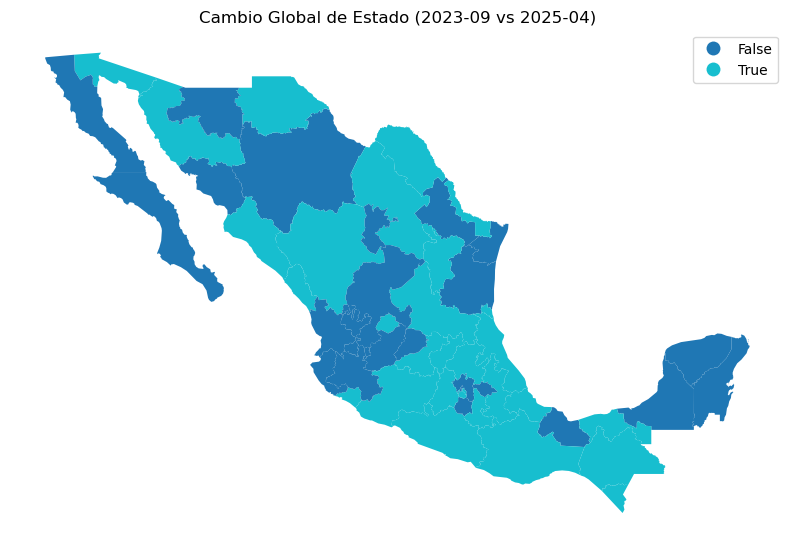

In [34]:
### Cambio del estado Global del índice

from mapclassify import NaturalBreaks

y1 = Data_Markov.iloc[:, 6:16].values

yb = np.empty_like(y1, dtype=int)

for t in range(y1.shape[1]):
    clasificador = NaturalBreaks(y1[:, t], k=5)
    yb[:, t] = clasificador.yb if len(np.unique(clasificador.yb)) == 5 else np.digitize(
        y1[:, t],
        np.percentile(y1[:, t], np.linspace(0, 100, 6)[1:-1])
    )

sm_2 = giddy.markov.Spatial_Markov(yb, w, 
                                   fixed = True,
                                   k = k, m = k)

#> Cambio Global
Data_Markov['C_G'] = (yb[:, -1] != yb[:, 0])

#> Cambio en algún momento
Data_Markov['C_M'] = (np.any(np.diff(yb, axis = 1) != 0, axis = 1))

#> Número de cambios
Data_Markov['N_C'] = np.sum(np.diff(yb, axis = 1) != 0, axis = 1)

#> Frecuencia de cambio
Cambio = np.diff(yb, axis=1) != 0
Data_Markov['F_C'] = np.sum(Cambio, axis = 1)

fig, ax = plt.subplots(figsize = (10, 8))
Data_Markov.plot(column = 'C_G',
                 categorical = True, legend = True, ax = ax)
plt.title('Cambio Global de Estado (2023-09 vs 2025-04)')
plt.axis('off')
plt.show()

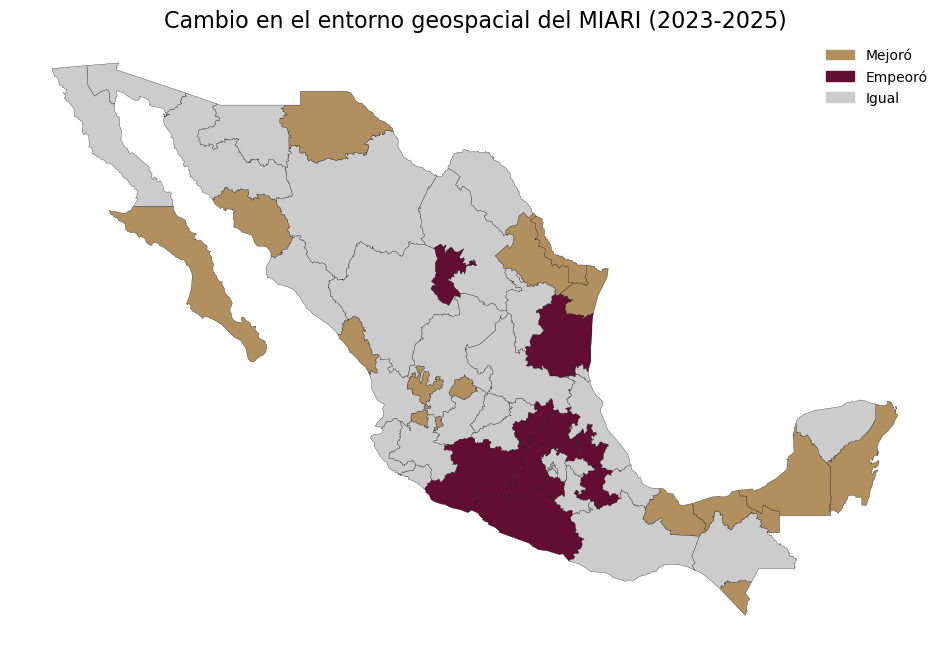

In [40]:
### Cambio del entorno espacial
import libpysal
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

#> Fechas a lag
fecha_inicial = yb[:, 0]  # 2023-09-01
fecha_final = yb[:, -1]   # 2025-04-01

#> 
# w.transform = 'r'


# Calcular el lag espacial para cada fecha
lag_inicial = libpysal.weights.lag_spatial(w, fecha_inicial)
lag_final = libpysal.weights.lag_spatial(w, fecha_final)

# Discretizar usando Natural Breaks (Jenks)
k = 5  # número de clases

nb_inicial = mc.NaturalBreaks(lag_inicial, k=k)
grupo_lag_inicial = nb_inicial.yb  # clases de 0 a 4

nb_final = mc.NaturalBreaks(lag_final, k=k)
grupo_lag_final = nb_final.yb


#> Grupo de Lag inicial
Data_Markov["G_Lag_I"] = grupo_lag_inicial

#> Grupo de Lag final
Data_Markov["G_Lag_F"] = grupo_lag_final


#> Anomalia de cambio
Cambio_A = grupo_lag_final - grupo_lag_inicial
Data_Markov["An_C"] = np.select([Cambio_A > 0, Cambio_A < 0, Cambio_A == 0], ['Mejoró', 'Empeoró', 'Igual'])


#> Colores de cambios
colores_cambio = {'Empeoró': '#630D32',
                  'Igual': '#cccccc', 
                  'Mejoró': '#B18F5F' }


# Graficar
fig, ax = plt.subplots(figsize = (12, 10))
Data_Markov.plot(column = 'An_C',
                 cmap = mcolors.ListedColormap([colores_cambio[c] for c in ['Empeoró', 'Igual', 'Mejoró']]),
                 legend=True,
                 categorical = True,
                 ax = ax,
                 edgecolor = '#000000',
                 linewidth = 0.2)

plt.title('Cambio en el entorno geospacial del MIARI (2023-2025)', fontsize = 16)
plt.axis('off')

#> Leyenda en caja
leyenda_cambio = [mpatches.Patch(color = colores_cambio[cat], 
                                 label = cat) for cat in ['Mejoró', 'Empeoró', 'Igual']]
plt.legend(handles = leyenda_cambio,
           title = '',
           loc = 'best').get_frame().set_linewidth(0)

plt.show()


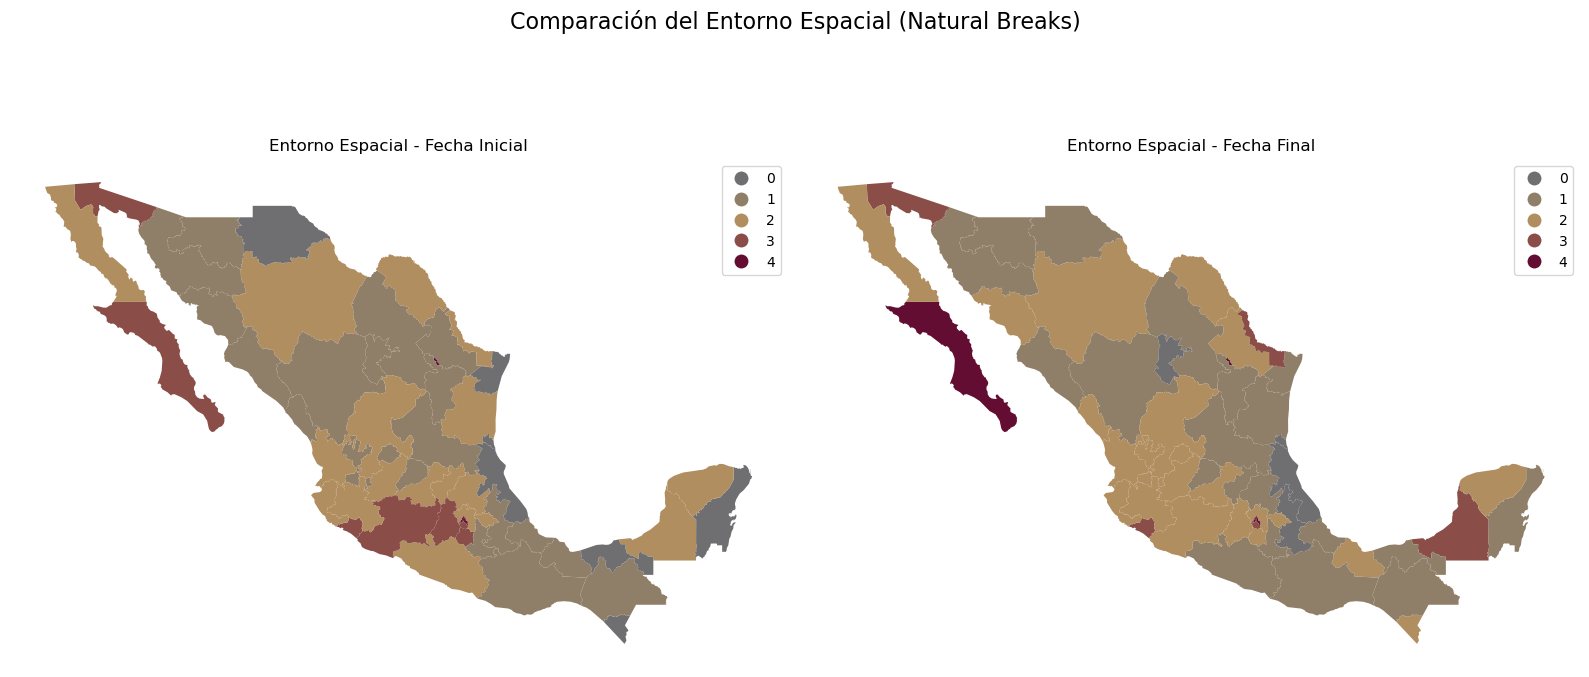

In [41]:
### Comparativos de las espacial
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Mapa 1: Lag Inicial
Data_Markov.plot(column = "G_Lag_I", categorical = True,
                 cmap = cmap_personalizado,
                 legend = True, ax = axes[0])
axes[0].set_title("Entorno Espacial - Fecha Inicial")
axes[0].axis("off")

# Mapa 2: Lag Final
Data_Markov.plot(column = "G_Lag_F", categorical = True,
                 cmap = cmap_personalizado,
                 legend = True, ax = axes[1])
axes[1].set_title("Entorno Espacial - Fecha Final")
axes[1].axis("off")

plt.suptitle("Comparación del Entorno Espacial (Natural Breaks)",
             fontsize = 16)
plt.tight_layout()
plt.show()

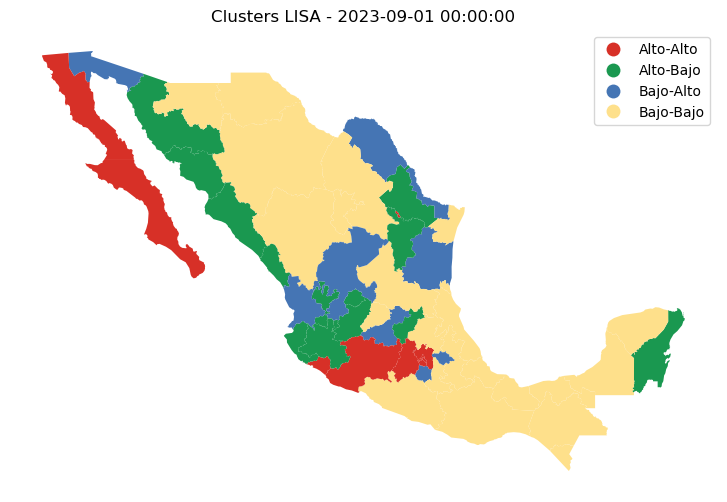

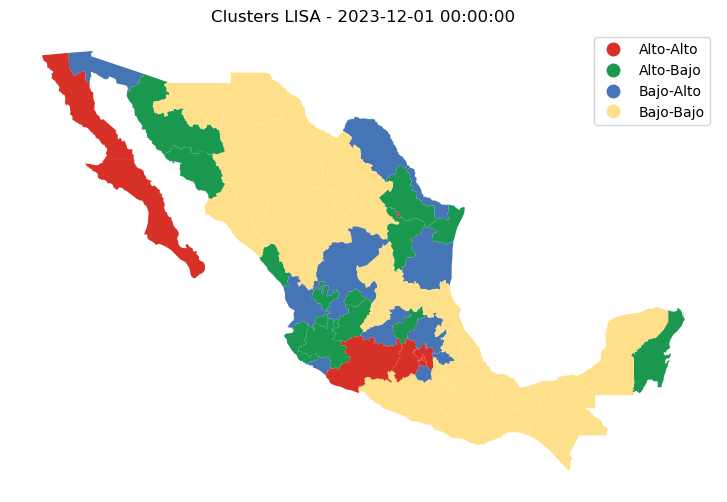

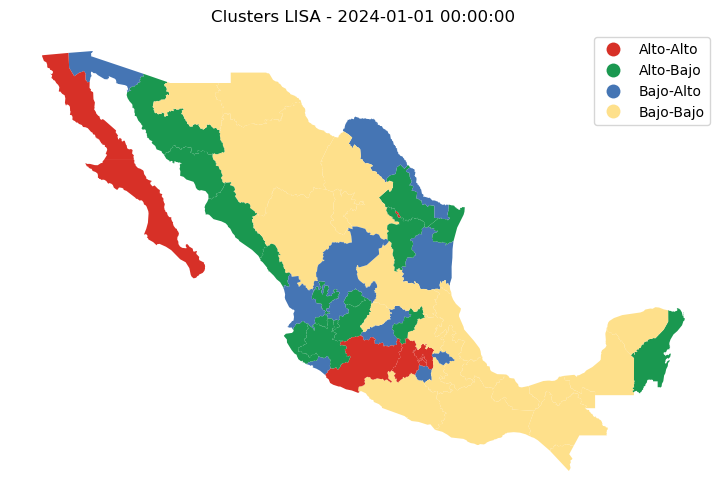

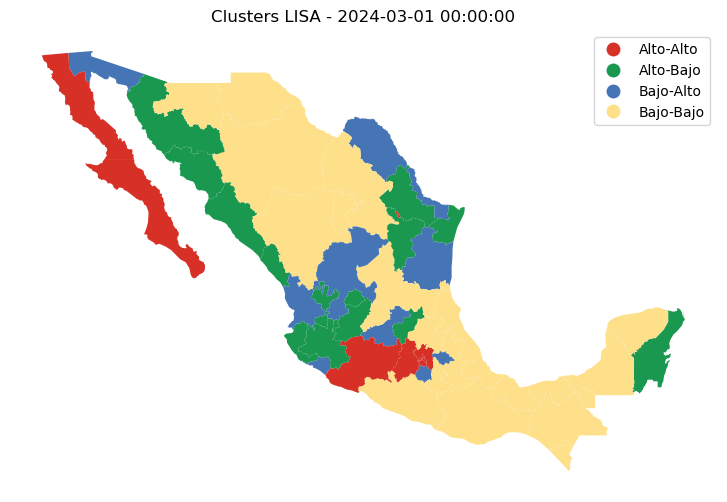

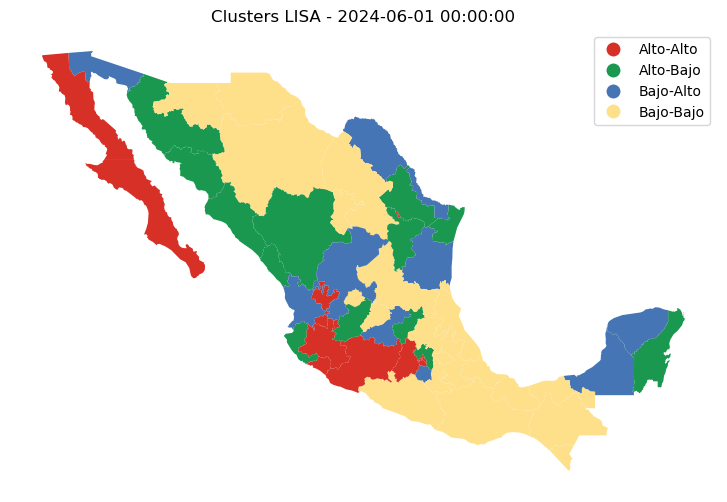

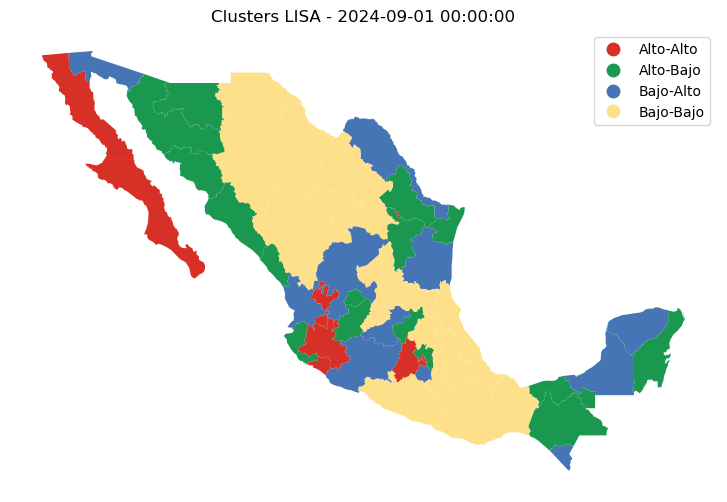

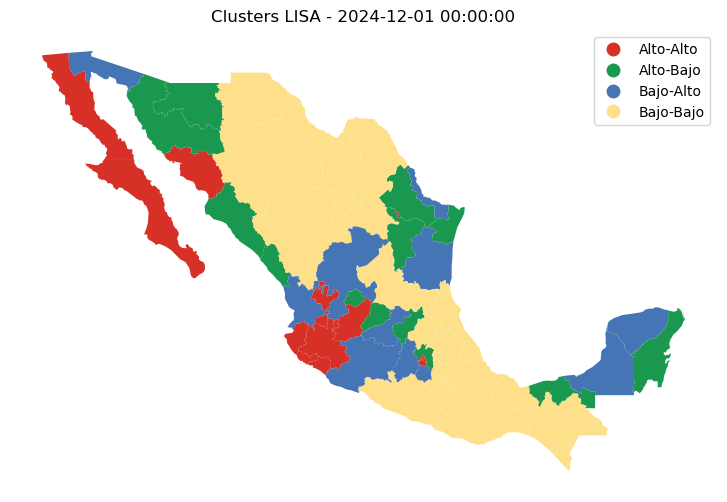

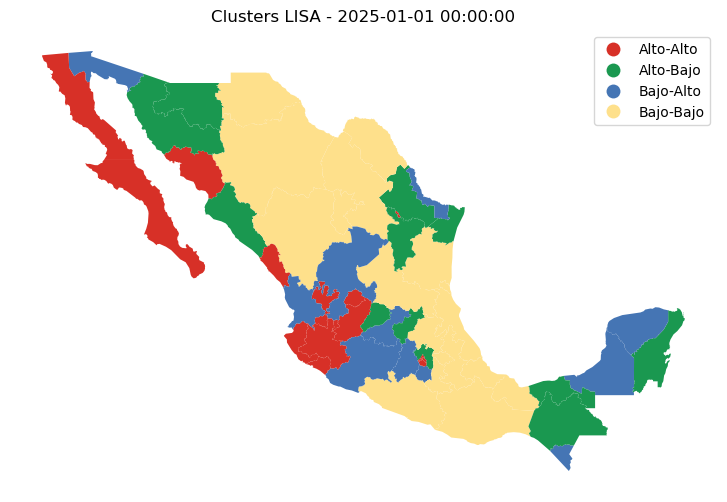

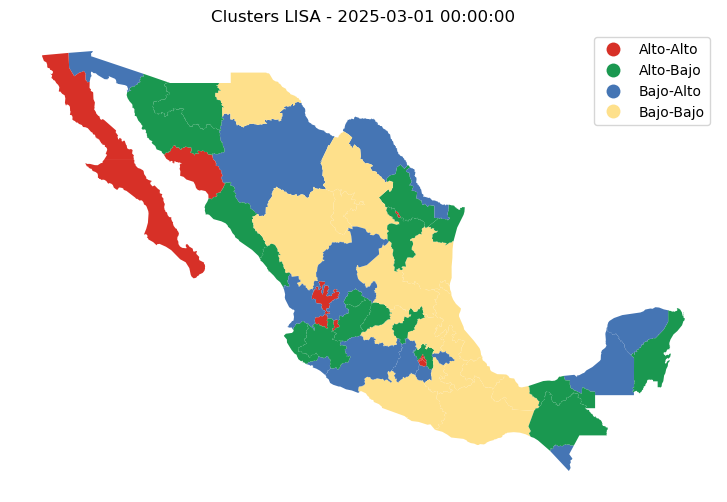

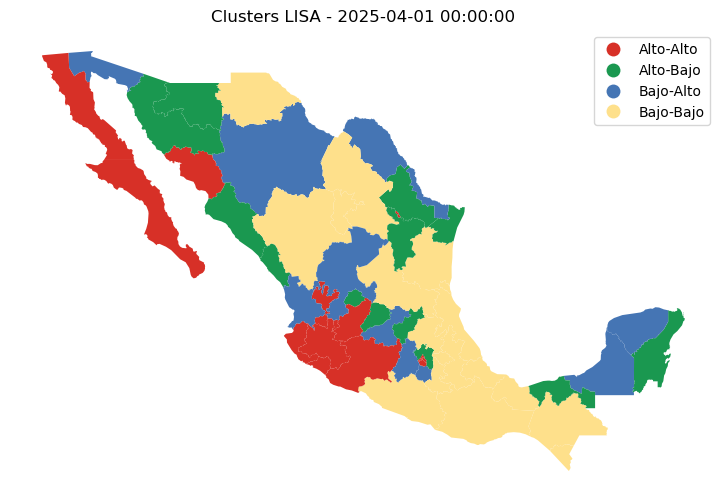

In [44]:
import matplotlib.colors as mcolors

columnas_periodos = Data_Markov.columns[6:16]

# Mapeo de códigos LISA a etiquetas
q_labels = {
    1: 'Alto-Alto',   # rojo
    2: 'Bajo-Alto',   # verde
    3: 'Bajo-Bajo',   # azul
    4: 'Alto-Bajo'    # amarillo
}

# Mapeo de etiquetas a colores personalizados
custom_colors = {
    'Alto-Alto': '#d73027',   # rojo
    'Bajo-Bajo': '#4575b4',   # azul
    'Alto-Bajo': '#fee08b',   # amarillo
    'Bajo-Alto': '#1a9850'    # verde
}

# Crear el colormap personalizado con valores fijos
cmap = mcolors.ListedColormap([custom_colors[label] for label in q_labels.values()])
bounds = list(range(5))  # 0-4 (usado por default internamente)
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Iterar y graficar
for col in columnas_periodos:
    y = Data_Markov[col].values
    moran_local = esda.Moran_Local(y, w, permutations=999)

    # Guardar valores
    Data_Markov[f'Is_{col}'] = moran_local.Is
    Data_Markov[f'p_sim_{col}'] = moran_local.p_sim
    Data_Markov[f'q_{col}'] = moran_local.q
    Data_Markov[f'q_label_{col}'] = pd.Series(moran_local.q).map(q_labels)

    # Graficar con colores personalizados
    fig, ax = plt.subplots(1, figsize=(10, 6))
    Data_Markov.plot(
        column=f'q_label_{col}',
        cmap=mcolors.ListedColormap([custom_colors[label] for label in q_labels.values()]),
        legend=True, categorical=True, ax=ax
    )
    ax.set_title(f'Clusters LISA - {col}')
    ax.axis('off')
    plt.show()


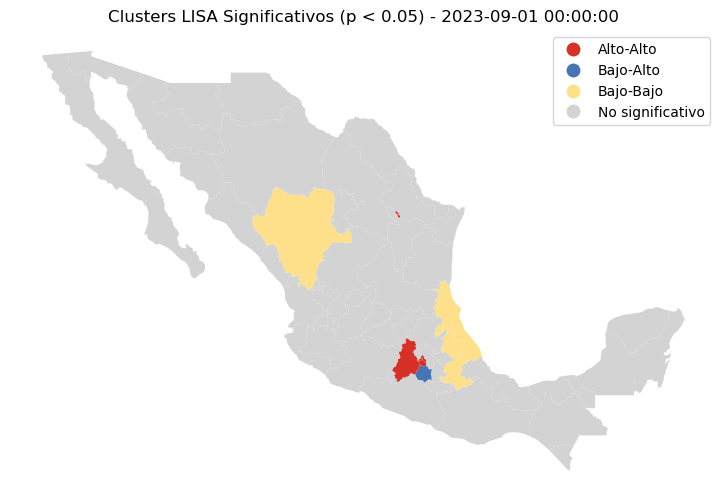

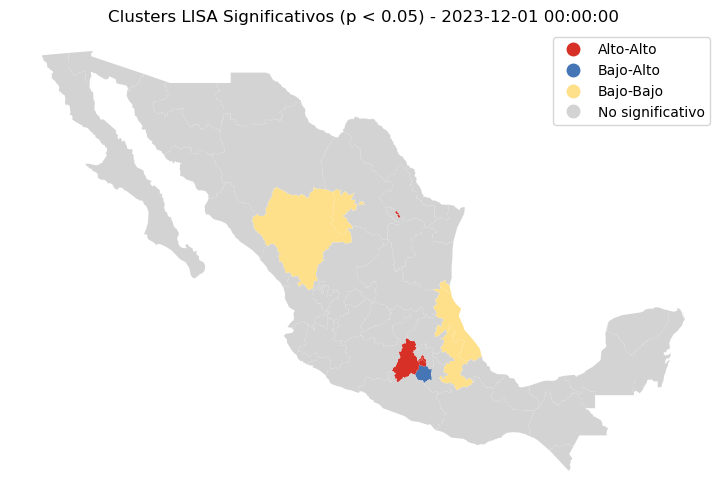

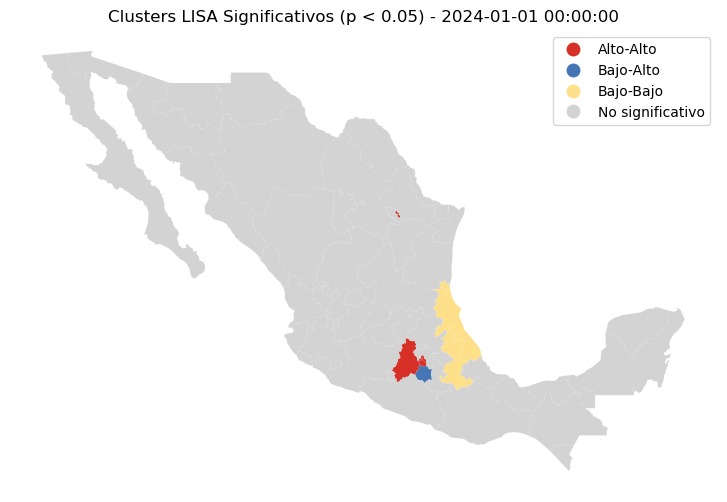

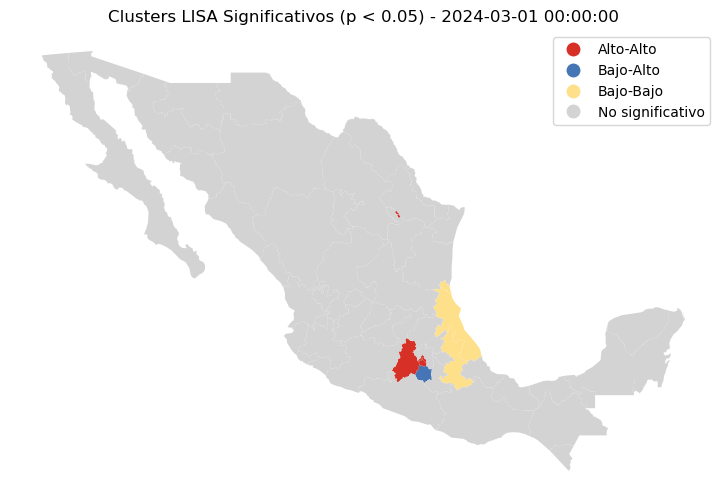

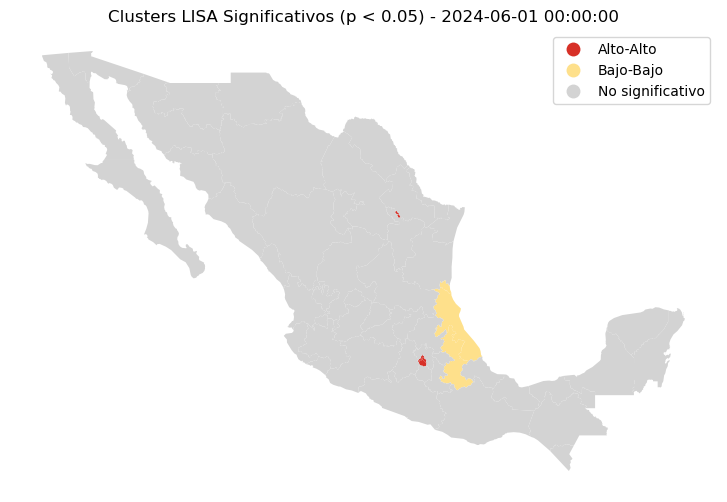

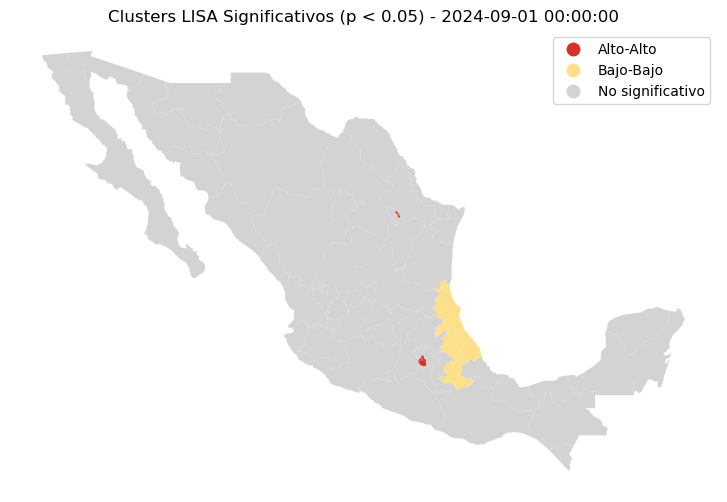

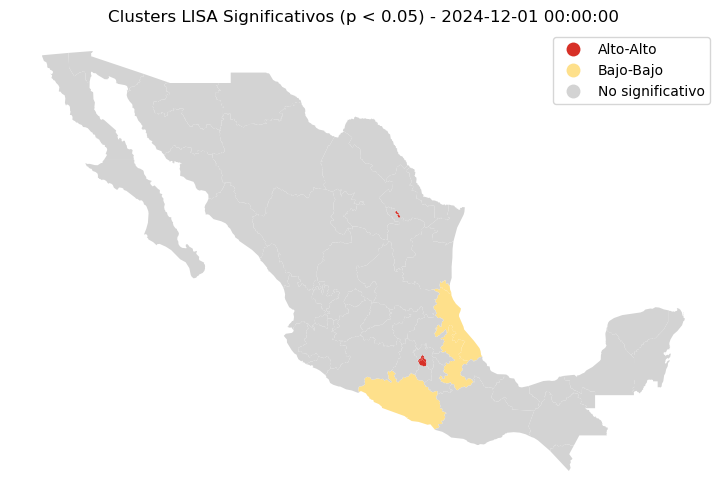

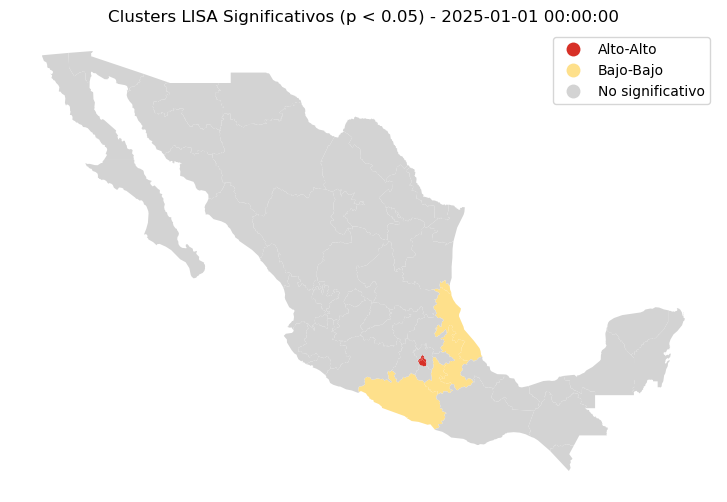

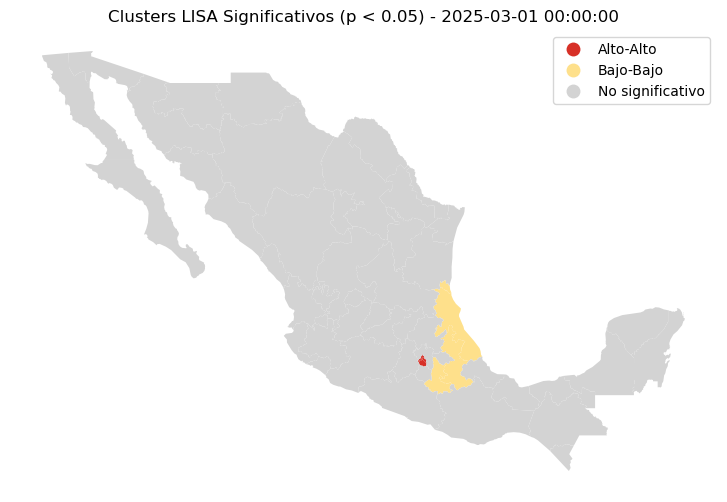

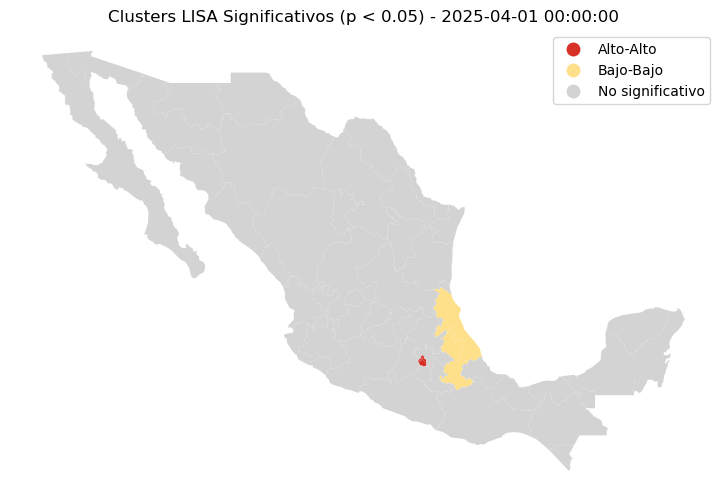

In [45]:
import matplotlib.colors as mcolors

columnas_periodos = Data_Markov.columns[6:16]

# Mapeo de códigos LISA a etiquetas
q_labels = {
    1: 'Alto-Alto',
    2: 'Bajo-Alto',
    3: 'Bajo-Bajo',
    4: 'Alto-Bajo'
}

# Colores personalizados por categoría
custom_colors = {
    'Alto-Alto': '#d73027',   # rojo
    'Bajo-Alto': '#1a9850',   # verde
    'Bajo-Bajo': '#4575b4',   # azul
    'Alto-Bajo': '#fee08b'    # amarillo
}

# Colormap listo para usar
cmap = mcolors.ListedColormap([custom_colors[label] for label in q_labels.values()])

for col in columnas_periodos:
    y = Data_Markov[col].values
    moran_local = esda.Moran_Local(y, w, permutations=999)

    # Guardar variables
    Data_Markov[f'Is_{col}'] = moran_local.Is
    Data_Markov[f'p_sim_{col}'] = moran_local.p_sim
    Data_Markov[f'q_{col}'] = moran_local.q

    # Asignar etiquetas SOLO si p < 0.05, si no → NaN
    significativos = moran_local.p_sim < 0.05
    etiquetas = pd.Series(moran_local.q).map(q_labels)
    etiquetas_filtradas = etiquetas.where(significativos)

    Data_Markov[f'q_sig_{col}'] = etiquetas_filtradas

    # Graficar solo los significativos
    fig, ax = plt.subplots(1, figsize=(10, 6))
    Data_Markov.plot(
        column=f'q_sig_{col}',
        cmap=cmap,
        categorical=True,
        legend=True,
        ax=ax,
        missing_kwds={"color": "lightgrey", "label": "No significativo"}
    )
    ax.set_title(f'Clusters LISA Significativos (p < 0.05) - {col}')
    ax.axis('off')
    plt.show()


In [49]:
from esda import Moran_Local
from giddy.markov import LISA_Markov
import numpy as np
import pandas as pd

columnas_periodos = Data_Markov.columns[6:16]

# Inicializar la matriz de clusters LISA
q_matrix = []

for col in columnas_periodos:
    y = Data_Markov[col].values
    lisa = Moran_Local(y, w, permutations=999)
    
    # Filtrar por significancia
    q_vals = lisa.q.copy()
    q_vals[lisa.p_sim >= 0.05] = 0  # No significativos como 0
    q_matrix.append(q_vals)

# Matriz Q (N unidades x T tiempos)
Q = np.array(q_matrix).T

# Crear modelo LISA_Markov
lm = LISA_Markov(Q, w)  # ← ¡aquí ya pasa w!

# Mostrar la matriz de transición
estados = ['HH', 'LH', 'LL', 'HL']
df_transicion = pd.DataFrame(lm.p, index=estados, columns=estados)
display(df_transicion)


C:\Users\LAAR8976\AppData\Local\anaconda3\envs\SAT_GEOGRAFICO\Lib\site-packages\giddy\markov.py:1415: RuntimeWarning: invalid value encountered in divide
  r = y / ybar
C:\Users\LAAR8976\AppData\Local\anaconda3\envs\SAT_GEOGRAFICO\Lib\site-packages\giddy\markov.py:1417: RuntimeWarning: divide by zero encountered in divide
  rlag = ylag / ybar
C:\Users\LAAR8976\AppData\Local\anaconda3\envs\SAT_GEOGRAFICO\Lib\site-packages\giddy\markov.py:1417: RuntimeWarning: invalid value encountered in divide
  rlag = ylag / ybar


,HH,LH,LL,HL
HH,0.890411,0.013699,0.068493,0.027397
LH,0.020833,0.802083,0.177083,0.000000
LL,0.006349,0.044444,0.946032,0.003175
HL,0.181818,0.000000,0.272727,0.545455


In [52]:
y_t = Data_Markov.iloc[:, 6:16].values
y_t

array([[3.59424334, 3.64772302, 3.64467454, 3.65194999, 3.56365977,
        3.5146843 , 3.46743362, 3.45585825, 3.42784073, 3.51226279],
       [3.6735485 , 3.68656275, 3.68321874, 3.67772057, 3.60326426,
        3.65493981, 3.69483506, 3.69566816, 3.6771558 , 3.68595066],
       [3.43868766, 3.43140653, 3.4466515 , 3.46665309, 3.45964167,
        3.48206023, 3.43654733, 3.40989437, 3.44880718, 3.47389071],
       [3.68236829, 3.80708959, 3.79843591, 3.79149425, 3.87412313,
        3.84780169, 3.84997921, 3.84603881, 3.8483421 , 3.88616722],
       [3.51269299, 3.46871376, 3.4538431 , 3.4486517 , 3.37847936,
        3.37589051, 3.44249267, 3.33378062, 3.35299237, 3.44691551],
       [4.15174765, 4.19148236, 4.1628017 , 4.23305376, 4.11304364,
        4.11491124, 4.08897535, 4.11792324, 4.21365734, 4.1831122 ],
       [3.30457915, 3.2815427 , 3.30140776, 3.30292141, 3.2801278 ,
        3.36446211, 3.44968028, 3.43157463, 3.43093694, 3.33890288],
       [3.51711633, 3.61230154, 3.6239537

In [53]:
lm = giddy.markov.LISA_Markov(y_t, w, permutations=1000)
"Chi2: %8.3f, p: %5.2f, dof: %d" % lm.chi_2

'Chi2:  925.230, p:  0.00, dof: 9'

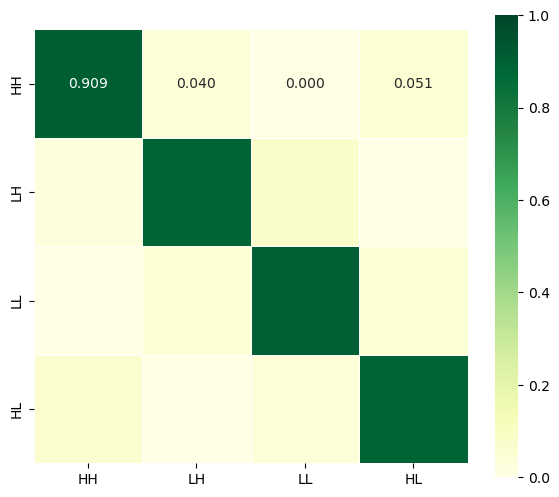

In [54]:
fig, ax = plt.subplots(figsize = (7,6))
im = sns.heatmap(lm.p, annot=True, linewidths=.5, ax=ax, cbar=True, vmin=0, vmax=1,
                 square=True,  cmap="YlGn",fmt='.3f', xticklabels=['HH', 'LH', 'LL', 'HL'],
                 yticklabels=['HH', 'LH', 'LL', 'HL'])